In [1]:
from functools import partial

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, ElectraTokenizerFast

from data import SNLIDataset
from data.utils import get_data, collate_fn_biencoder

from model import NLIBiEncoder

from training import Trainer

# Data

In [2]:
train, test, val = get_data('snli_1.0')

In [3]:
LABELS = ['entailment', 'contradiction', 'neutral']
NUM_LABELS = len(LABELS)

train = train[train.target.isin(set(LABELS))]
val = val[val.target.isin(set(LABELS))]
test = test[test.target.isin(set(LABELS))]

In [4]:
train.head()

,sentence1,sentence2,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
target2idx = {l: i for i, l in enumerate(LABELS)}
train.target = train.target.map(target2idx)
val.target = val.target.map(target2idx)
test.target = test.target.map(target2idx)

In [6]:
electra_tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')

In [7]:
train_dataset = SNLIDataset(train.sentence1.tolist(), train.sentence2.tolist(), train.target.tolist())
val_dataset = SNLIDataset(val.sentence1.tolist(), val.sentence2.tolist(), val.target.tolist())

In [8]:
collate_fn_biencoder = partial(collate_fn_biencoder, tokenizer=electra_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn_biencoder)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_biencoder)

# Model

In [9]:
electra = AutoModel.from_pretrained('google/electra-base-discriminator')

In [10]:
model = NLIBiEncoder(electra, NUM_LABELS, lambda x: x.last_hidden_state[:, 0, :])

In [11]:
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion, 'electra/v1/electra_snli.pt', 'electra/v1/electra_optimizer.pt', lr=1e-4, device='cuda:0')

# Training

In [12]:
trainer.train(train_loader, val_loader, num_epochs=20, frozen_encoder_epochs=1)

Epoch 1/20:


Mean loss: 0.9839767009019852. Current progress: : 100%|██████████| 8584/8584 [13:06<00:00, 10.92it/s]


Mean training loss: 1.0065331437033909. Mean validation loss: 0.9145327194944605.
Training accuracy: 0.4909741575303941. Validation accuracy: 0.5710504885993485.
Epoch 2/20:


Mean loss: 0.6253678979873657. Current progress: : 100%|██████████| 8584/8584 [41:46<00:00,  3.42it/s]


Mean training loss: 0.7005951123074294. Mean validation loss: 0.5772604977155661.
Training accuracy: 0.701070504780957. Validation accuracy: 0.7652687296416938.
Epoch 3/20:


Mean loss: 0.5685007818937302. Current progress: : 100%|██████████| 8584/8584 [42:22<00:00,  3.38it/s]


Mean training loss: 0.581879331463842. Mean validation loss: 0.5250601747206279.
Training accuracy: 0.7641795011349426. Validation accuracy: 0.7881718241042345.
Epoch 4/20:


Mean loss: 0.5233596307039261. Current progress: : 100%|██████████| 8584/8584 [41:38<00:00,  3.44it/s]


Mean training loss: 0.5264748198215443. Mean validation loss: 0.5058652963731196.
Training accuracy: 0.7916875240049002. Validation accuracy: 0.8009975570032574.
Epoch 5/20:


Mean loss: 0.47980536353588105. Current progress: :  96%|█████████▌| 8253/8584 [41:02<01:45,  3.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Mean loss: 0.44420174595713613. Current progress: :  29%|██▉       | 2532/8584 [12:08<27:45,  3.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Mean loss: 0.44861232990026473. Current progress: :  62%|██████▏   | 5360/8584 [25:24<16:47,  3.20it/s]IOPub message rate exceeded.
The notebook

Mean training loss: 0.41204927737051267. Mean validation loss: 0.4933557492959035.
Training accuracy: 0.8422984999098962. Validation accuracy: 0.8148412052117264.
Epoch 8/20:


Mean loss: 0.39005988839268685. Current progress: : 100%|██████████| 8584/8584 [41:33<00:00,  3.44it/s]


Mean training loss: 0.38349336846267246. Mean validation loss: 0.5099576131089941.
Training accuracy: 0.8546672807067043. Validation accuracy: 0.8132125407166124.
Epoch 9/20:


Mean loss: 0.36143956443667413. Current progress: : 100%|██████████| 8584/8584 [41:24<00:00,  3.45it/s]


Mean training loss: 0.35570858104999864. Mean validation loss: 0.5309607165974456.
Training accuracy: 0.8665555084306119. Validation accuracy: 0.8163680781758957.
Epoch 10/20:


Mean loss: 0.34089861795306203. Current progress: : 100%|██████████| 8584/8584 [41:33<00:00,  3.44it/s]


Mean training loss: 0.33137195034495937. Mean validation loss: 0.5523411157456312.
Training accuracy: 0.876328574523042. Validation accuracy: 0.8164698697068404.
Epoch 11/20:


Mean loss: 0.32025456479191783. Current progress: : 100%|██████████| 8584/8584 [42:38<00:00,  3.35it/s]


Mean training loss: 0.30915450260133415. Mean validation loss: 0.54501163814362.
Training accuracy: 0.8856210875425717. Validation accuracy: 0.8170806188925082.
Epoch 12/20:


Mean loss: 0.296802018687129. Current progress: : 100%|██████████| 8584/8584 [42:24<00:00,  3.37it/s]  


Mean training loss: 0.28932674152417265. Mean validation loss: 0.5952730529107056.
Training accuracy: 0.8932808122803153. Validation accuracy: 0.8186074918566775.
Epoch 13/20:


Mean loss: 0.2743924432992935. Current progress: : 100%|██████████| 8584/8584 [41:58<00:00,  3.41it/s] 


Mean training loss: 0.2705156660542406. Mean validation loss: 0.6238592669561311.
Training accuracy: 0.9005655599990534. Validation accuracy: 0.8187092833876222.
Epoch 14/20:


Mean loss: 0.2565282053351402. Current progress: : 100%|██████████| 8584/8584 [41:22<00:00,  3.46it/s] 


Mean training loss: 0.2537348670268714. Mean validation loss: 0.6573271498858154.
Training accuracy: 0.9074644090380384. Validation accuracy: 0.813314332247557.
Validation performance has started degrading. Performing early stopping.


NLIBiEncoder(
  (encoder): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

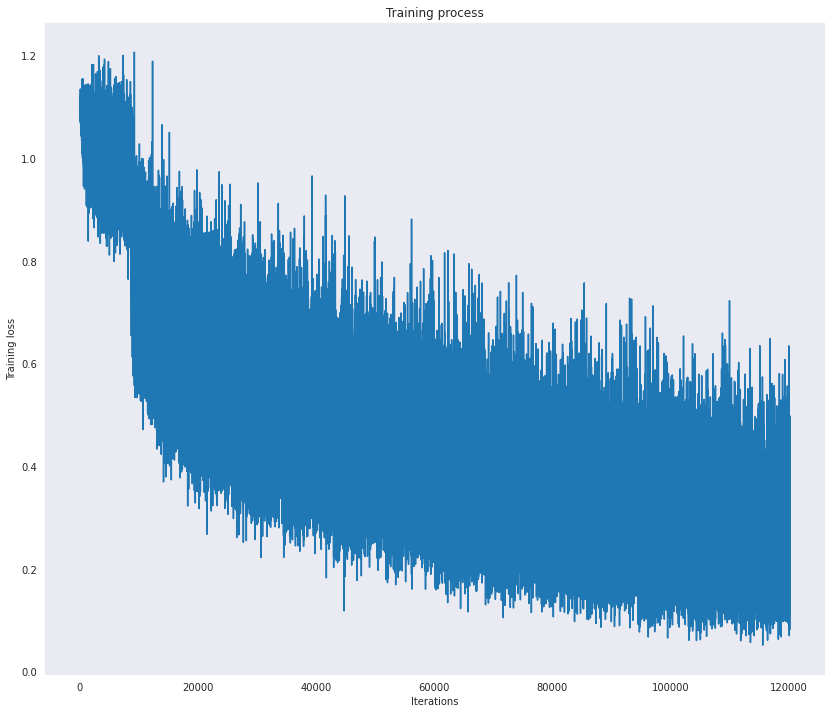

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(trainer.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');